# OPF_SOCP_ieee33bus


---
## Python Implementation

We import the Gurobi Python Module and other Python libraries.

Add a theta constraints

In [1]:
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import math as math
import time

In [2]:
import NRpowerflow_0_13 as nr
import matplotlib.pyplot as plt

## Input Data
We define all the input data of the model.\

### Generate Bus, Line, DER Data for inital state

In [3]:
def Read_File():
    Bus_file = [r'data/Bus_33.txt','Bus']
    Line_file = [r'data/Line_33.txt','Line']
    LoadProfile = [r"data/Load_for_scheduling.txt", 'LoadProfile']
    PVProfile = [r"data/PV_for_scheduling.txt", 'PVProfile']

    #Read Bus Data
    [buses,generators,loads] = nr.Read_File(Bus_file)

    #Read Line Data
    branches = nr.Read_File(Line_file)

    #Load Profile
    loadprofiles = nr.Read_File(LoadProfile)

    #PV Profile
    pvprofiles = nr.Read_File(PVProfile)

    #DER Profile
    scale_factor = 70
    # DER DATA
    # DER unit: MW, MVA
    #DER_Bus = np.array([[10],[15],[19],[22],[27],[34],[41],[61]])
    DER_Bus = np.array([[10],[18],[19],[22],[25],[27],[31],[33]])
    DER_Type = np.array([['ESS'],['PV'],['PV'],['ESS'],['PV'],['ESS'],['PV'],['PV']])
    DER_Type = np.array([['PV'],['PV'],['PV'],['ESS'],['PV'],['PV'],['PV'],['PV']])
    
    DER_Company = np.array([[''],[''],[''],['HYOSUNG'],[''],[''],[''],['']])
    DER_P = np.array([[20],[15],[10],[25],[15],[10],[15],[20]])/1000*scale_factor
    #DER_P = np.array([[0],[0],[0],[0],[0],[0],[0],[0]])/1000
    DER_Q = np.array([[0],[0],[0],[0],[0],[0],[0],[0]])/1000
    DER_List = np.c_[DER_Bus,DER_Type, DER_Company, DER_P,DER_Q]
    DER_List = np.array(DER_List, dtype=object)
    ders = nr.DERmapping(DER_List)

    # LOAD P/Q FOR EACH BUS
    sets = [loads,generators,ders]
    generator_factor = 1
    load_factor = 2
    factors = [generator_factor, load_factor]

    # Parameters
    # CONSTRUCT ADMITTANCE MATRIX
    Ymat = nr.GenerateYmatrix(buses, branches)

    busmatrix = nr.Generate_Busmatrix(buses, sets, factors, [1,1])
    dermatrix = nr.Generate_DERmatrix(ders)
  
    return busmatrix, dermatrix, Ymat, branches, buses

# Functions related to electrical grids

In [4]:
def Adj_buses(i,branches,option):
    #option = all, From, To
    # if From -> only show the From nodes
    # if To -> only show the To nodes
    tbuses = []
    ls = []
    count = 1
    tbuses.append(i)
    for branch in branches:
        
        if branch.J == i+1 and option is not 'To':
            tbuses.append(branch.I -1)
            ls.append(count)
            count += 1
        if branch.I == i+1 and option is not 'From':
            tbuses.append(branch.J -1)
            ls.append(count)
            count += 1
            
    #return (tbuses,ls)   
    return tbuses

### Add Parameters:
- $ N_b $: Number of buses
- $ \mathcal{B} $: Bus index where 1, ..., $ N_b $  
- $ \mathcal{G} \hspace{0.2cm} \subseteq N_b $ : Generator Index 
- $ \mathcal{L} $: Line nonzero $(i,j)$ tuple $\forall (i,j) \in \mathcal {B} $


- $ V_{max} $ = maximum allowable Voltage in p.u.
- $ V_{min} $ = minimum allowable Voltage in p.u.
- $ bounds(PQ_{src}) = [ min(P_{src}), max(P_{src}), min(Q_{src}), max(Q_{src})]) $
- $ bounds(PQ_{g}) = [ min(P_{g}^i), max(P_{g}^i), min(Q_{g}^i), max(Q_{g}^i)] 
\hspace{0.2cm}  \forall i \in \mathcal{G} $

- $ G_{ij}, B_{ij}  = real(Y_{ij}), imag(Y_{ij}) \hspace{0.2cm}  \forall (i,j) \in \mathcal{L} $
= Conductance and Susecptance matrix



In [5]:
def add_Parameters(busmatrix, dermatrix):

    Psrc_min = -15.0 #MW
    Psrc_max = 15.0 
    Qsrc_min = -15.0 #MVAR
    Qsrc_max = 15.0
    
    PQsrc_bounds = [Psrc_min, Psrc_max,Qsrc_min, Qsrc_max]
    
    
    Vmax = 1.1 #p.u.
    Vmin = 0.9 #p.u.
    
    bus_index = busmatrix['BUS']-1
    gen_index = dermatrix['BUS']-1
    Pgen_max = dermatrix['PG']
    Pgen_min = - dermatrix['QG']
    Qgen_max = dermatrix['QG']
    Qgen_min = -dermatrix['QG']
    
    PQgen_bounds = [Pgen_min, Pgen_max, Qgen_min, Qgen_max]
    
    return bus_index, gen_index, Vmax, Vmin, PQsrc_bounds, PQgen_bounds

### Add Variables:

- $P_{src} $: Source Power Output (active)
- $Q_{src} $: Source Power Output (reactive)

- $P_g^i \hspace{0.2cm} \forall i \in \mathcal{G}$: Generator Power Output (active)
- $Q_g^i \hspace{0.2cm} \forall i \in \mathcal{G}$: Generator Power Output (reactive)

- $P_{ij} \hspace{0.2cm} \forall (i,j) \mathcal{L}$: Line Power (active) 
- $Q_{ij} \hspace{0.2cm} \forall (i,j) \mathcal{L}$: Line Power (reactive)

- $c_{ij} \hspace{0.2cm} \forall (i,j) \in \mathcal{L}$: 
- $s_{ij} \hspace{0.2cm} \forall (i,j) \mathcal{L}$: 

In [6]:
def add_Variables(model,bus_index, gen_index, Vmax, Vmin, PQsrc_bounds, PQgen_bounds):
    
    PG = {}
    QG = {}
    cij = {}
    sij = {}
    Theta = {}
    
    Psrc = model.addVar(lb = PQsrc_bounds[0], ub=PQsrc_bounds[1],name='Psrc')
    Qsrc = model.addVar(lb = PQsrc_bounds[2], ub=PQsrc_bounds[3],name='Qsrc')
    
    for i in range(len(gen_index)):
        gen = gen_index[i]
        PG[gen] = model.addVar(lb = PQgen_bounds[0][i], ub = PQgen_bounds[1][i],vtype=GRB.CONTINUOUS,  name = 'PG')
        QG[gen] = model.addVar(lb = PQgen_bounds[2][i], ub = PQgen_bounds[3][i],vtype=GRB.CONTINUOUS,  name = 'QG')

    for i in bus_index:
        Theta[i] = model.addVar(lb = -np.pi, ub= np.pi, name = 'Theta')
        for j in Adj_buses(i,branches,''):  
            cij[i,j] = model.addVar(lb = 0*0, ub = Vmax*Vmax, name = 'Cij')
            sij[i,j] = model.addVar(lb = - GRB.INFINITY, name = 'Sij')    
    
    return Psrc, Qsrc, PG, QG, Theta, cij, sij

### Add Constraints:

- $P_{cal} = $: Source Power Output (active)
- $Q_{cal} = $: Source Power Output (reactive)

In [7]:
def Pcal(i, cij, sij, G, B, bus_index):
    #a = C[i, i] * g[i, i]
    Pcal = B[i, i] * sij[i, i] 
    for j in Adj_buses(i,branches,''):
        Pcal += G[i,j]*cij[i,j] - B[i,j]*sij[i,j]
    return (Pcal)

def Qcal(i,cij,sij, g, b, bus_index):
    Qcal =  G[i, i] * sij[i, i]
    for j in Adj_buses(i,branches,''):
        Qcal += - B[i,j]*cij[i,j] - G[i,j]*sij[i,j]
    return (Qcal)

In [15]:
def add_PQbalance_Constraints(model,cij, sij, G, B, PG, QG, PL, QL, bus_index, gen_index):
    
    # index 0 is for slack
    nongen_index = list(set(bus_index)-set(gen_index))[1:]
    
    Pgen_balance = model.addConstrs((Pcal(i, cij, sij, G, B, bus_index)== PG[i] - PL[i]) for i in gen_index)
    Qgen_balance = model.addConstrs((Qcal(i, cij, sij, G, B, bus_index)== QG[i] - QL[i]) for i in gen_index)
    
    noPgen_balance = model.addConstrs((Pcal(i, cij, sij, G, B, bus_index)==  - PL[i]) for i in nongen_index)
    noQgen_balance = model.addConstrs((Qcal(i, cij, sij, G, B, bus_index)==  - QL[i]) for i in nongen_index)
    
    return Pgen_balance, Qgen_balance, noPgen_balance, noQgen_balance    

In [16]:
def add_C_S_Constraints(model, cij,sij, bus_index):
    ClimInit = model.addConstr(cij[0,0]==1.0*1.0, name= 'ClimInit') # Slack Initial Voltage 
    #ClimUP = model.addConstrs((cij[i, i]<= Vmax*Vmax for i in bus_index),name='ClimUP')
    #ClimLow = model.addConstrs((cij[i, i]>= Vmin*Vmin for i in bus_index),name='ClimLow') 
    Cconst = model.addConstrs((cij[i, j]== cij[j, i] for i in bus_index for j in Adj_buses(i,branches,'')  ),name='C_Constrs')
    Sconst = model.addConstrs((sij[i, j]== - sij[j, i] for i in bus_index for j in Adj_buses(i,branches,'')  ),name='S_Constrs')
    
    for i in bus_index:
        for j in Adj_buses(i,branches,''):
            CS_Q_const = model.addQConstr((cij[i, j]*cij[i, j]+sij[i, j]*sij[i, j])<=cij[i, i]*cij[j, j])
    
    return ClimInit, Cconst, Sconst, CS_Q_const

In [8]:
def add_Theta_Constraints(model, Theta, cij,sij, bus_index):
    
    Thinit = model.addConstr(Theta[0] == 0)
    
    #Thconst = model.addConstrs((Theta[i]-Theta[j] == math.atan2(sij[i,j],cij[i,j]) 
    #                               for i in bus_index for j in Adj_buses(i,branches,'From')), name= 'Theta_const')
    #Thconst = model.addConstrs((np))
    Th = {}
    Thc = {}
    Thconst = {}
    for i in bus_index:
        for j in Adj_buses(i,branches,'From'):
            Th[i,j]= model.addVar(name='Th')
            z = model.addVar(lb=-GRB.INFINITY)
            model.addConstr(z == Theta[i]-Theta[j])
            Thc[i,j] = model.addGenConstrTan(z, Th[i,j])
            zz = model.addVar(lb=-GRB.INFINITY)
            
            model.addQConstr(zz == cij[i,j]*Th[i,j])
            Thconst[i,j] = model.addConstr(zz == sij[i,j])
    return Th, Thc, Thinit, Thconst



In [ ]:
def add_Objectives(model,Psrc, cij,sij, G, B, bus_index):
    #Psrc = - constrainp(0)
    
    Pcal_src = m.addConstr(Psrc == Pcal(0, cij, sij, G, B, bus_index), 'Pcal_src')
    obj = 0.097*1000000 * Psrc* Psrc + 210 * 1000 * Psrc + 32000

    #obj = gp.quicksum(0.097 * active_power_diat[diat]* active_power_diat[diat] + 210 * active_power_diat[diat]
#                         + 32000 for diat in generate_ac_diat)
    return Pcal_src, obj

In [9]:
m = gp.Model('SOCP_OPF')
busmatrix, dermatrix, Ymat, branches, buses = Read_File()
bus_index, gen_index, Vmax, Vmin, PQsrc_bounds, PQgen_bounds = add_Parameters(busmatrix,dermatrix)
Psrc, Qsrc, PG, QG, Theta, cij, sij = add_Variables(m,bus_index, gen_index, Vmax, Vmin, PQsrc_bounds, PQgen_bounds)

PL,QL = busmatrix['PL'], busmatrix['QL'] 
G,B = np.real(Ymat), np.imag(Ymat)
PG_bal, QG_bal, noPG_bal, noQG_bal = add_PQbalance_Constraints(m,cij, sij, G, B, PG, QG, PL, QL, bus_index, gen_index)
ClimInit, Cconst, Sconst, CS_Q_const = add_C_S_Constraints(m, cij,sij, bus_index) 
Pcal_src, obj = add_Objectives(m,Psrc, cij,sij, G, B, bus_index)
#Th, Thc, Thinit, Thconst = add_Theta_Constraints(m, Theta, cij,sij, bus_index)

Academic license - for non-commercial use only - expires 2022-03-25
Using license file C:\Users\user\gurobi.lic


In [10]:
m.setObjective(obj, GRB.MINIMIZE)
startop = time.time()
m.optimize()
endop = time.time()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 260 rows, 245 columns and 626 nonzeros
Model fingerprint: 0xd1318df0
Model has 1 quadratic objective term
Model has 97 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 2e+03]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [2e+05, 2e+05]
  QObjective range [2e+05, 2e+05]
  Bounds range     [7e-01, 2e+01]
  RHS range        [2e-02, 1e+00]
Presolve removed 131 rows and 76 columns
Presolve time: 0.01s
Presolved: 388 rows, 299 columns, 967 nonzeros
Presolved model has 65 second-order cone constraints
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.631e+03
 Factor NZ  : 4.674e+03
 Factor Ops : 6.125e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   3.20000021e+04 

In [11]:
def Pcaltest(i, cij, sij, G, B, bus_index):
    #a = C[i, i] * g[i, i]
    Pcal = B[i, i] * sij[i, i].x 
    for j in bus_index:
        Pcal += G[i,j]*cij[i,j].x - B[i,j]*sij[i,j].x
    return (Pcal)

def Qcaltest(i,cij,sij, g, b, bus_index):
    Qcal =  G[i, i] * sij[i, i]
    for j in bus_index:
        Qcal += -B[i,j]*cij[i,j].x - G[i,j]*sij[i,j].x
    return (Qcal)

In [12]:
Vopf = np.zeros(len(bus_index))
for i in bus_index:
    for j in  bus_index:
        if i ==j:
            Vopf[i] = np.sqrt(cij[i,j].x)

Thopf = np.zeros(len(busmatrix))
Thopf[0] = 0

for i in bus_index:
    for j in Adj_buses(i,branches,'From'):
        Thopf[i] = Thopf[j] - math.atan2(sij[i,j].x, cij[i,j].x)
          

****************************
IEEE 33 BUS NETWORK
Total Loads: [7.43, 4.6] [MW, MVAR]
Total DERs:  [9.1] MW
Total Time (nn):  [0.10700011253356934] [s]
Total Time: (opf) [0.038997650146484375] [s]
****************************



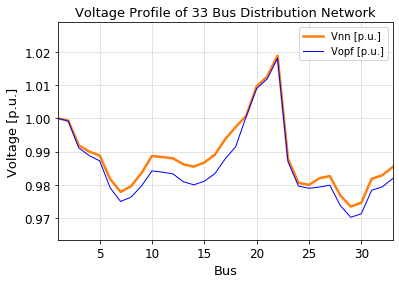

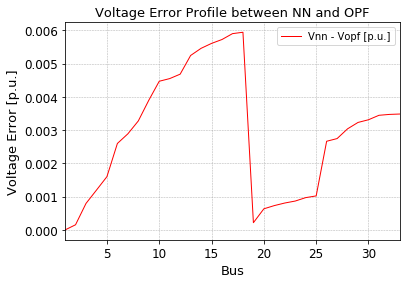

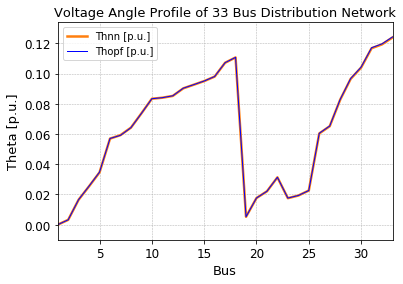

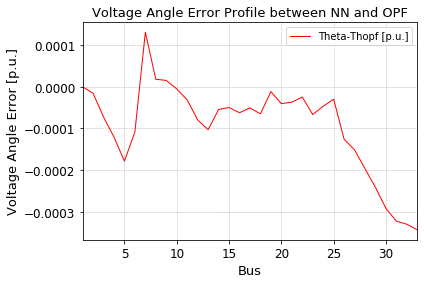

In [13]:
# REARRANGE BUS : slack -> PQ -> PV
# COUNT Slack, PV and PQ BUS
#Read Bus Data
[orderedbuses,NumBus] = nr.Rearrange_bus(buses)
Pbus = busmatrix['PG'] - busmatrix['PL'] 
Qbus = busmatrix['QG'] - busmatrix['QL'] 

Bus_file = [r'data/Bus_33.txt','Bus']
Line_file = [r'data/Line_33.txt','Line']
LoadProfile = [r"data/Load_for_scheduling.txt", 'LoadProfile']
PVProfile = [r"data/PV_for_scheduling.txt", 'PVProfile']

#Read Bus Data
[buses,generators,loads] = nr.Read_File(Bus_file)
DER_Bus = np.array([[10],[18],[19],[22],[25],[27],[31],[33]])
DER_Type = np.array([['ESS'],['PV'],['PV'],['ESS'],['PV'],['ESS'],['PV'],['PV']])
DER_Type = np.array([['PV'],['PV'],['PV'],['ESS'],['PV'],['PV'],['PV'],['PV']])

DER_Company = np.array([[''],[''],[''],['HYOSUNG'],[''],[''],[''],['']])
x = 0
DER_P = np.zeros(len(PG))
for gen in PG:
    DER_P[x] = PG[gen].x
    x += 1
    #DER_P = np.array([[0],[0],[0],[0],[0],[0],[0],[0]])/1000
DER_Q = np.array([[0],[0],[0],[0],[0],[0],[0],[0]])/1000
DER_List = np.c_[DER_Bus,DER_Type, DER_Company, DER_P,DER_Q]
DER_List = np.array(DER_List, dtype=object)
dersx = nr.DERmapping(DER_List)

# LOAD P/Q FOR EACH BUS
setsx = [loads,generators,dersx]
generator_factor = 1
load_factor = 2
factors = [generator_factor, load_factor]

# Parameters
# CONSTRUCT ADMITTANCE MATRIX
Ymat = nr.GenerateYmatrix(buses, branches)

busmatrixx = nr.Generate_Busmatrix(buses, setsx, factors, [1,1])
dermatrixx = nr.Generate_DERmatrix(dersx)
[orderedbusesx,NumBus] = nr.Rearrange_bus(buses)
Pbusx = busmatrixx['PG'] - busmatrixx['PL'] 
Qbusx = busmatrixx['QG'] - busmatrixx['QL'] 
[Vx, Thetax, Jx] = nr.SolvePowerFlow(orderedbusesx, [Pbusx, Qbusx], Ymat, NumBus)




startnn = time.time()
[V, Theta, J] = nr.SolvePowerFlow(orderedbuses, [Pbus, Qbus], Ymat, NumBus)
endnn = time.time()    
sumPL = np.round(np.sum(busmatrix['PL']),2)
sumQL = np.round(np.sum(busmatrix['QL']),2)
sum_Pder = np.round(np.sum(busmatrix['PG']),2)

# PRINT THE BRIEF lOADS AND DERS DATA
print("****************************")
print("IEEE 33 BUS NETWORK")
print("Total Loads:", [sumPL, sumQL], "[MW, MVAR]")
print("Total DERs: ", [sum_Pder], "MW")
print("Total Time (nn): ", [endnn - startnn], "[s]")
print("Total Time: (opf)", [endop - startop], "[s]")

print("****************************")
print("") 

# Plot the Voltage Profile
plt.plot(busmatrix['BUS'],V, label='Vnn [p.u.]', linewidth=2.5, color = '#ff7f0e')
plt.plot(busmatrix['BUS'],Vopf, label='Vopf [p.u.]', linewidth=1, color = 'blue')
plt.ylabel('Voltage [p.u.]', fontsize=13)
plt.xlabel('Bus', fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(busmatrix['BUS'][0],busmatrix['BUS'][len(V)-1])
plt.ylim(min(V)-0.01,max(V)+0.01)
plt.title('Voltage Profile of 33 Bus Distribution Network', fontsize=13)
plt.legend(fontsize=10)
plt.grid(linestyle='--', linewidth=0.5)
plt.show() 

plt.plot(busmatrix['BUS'],np.subtract(V,Vopf), label='Vnn - Vopf [p.u.]', linewidth=1, color = 'red')
plt.ylabel('Voltage Error [p.u.]', fontsize=13)
plt.xlabel('Bus', fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(busmatrix['BUS'][0],busmatrix['BUS'][len(V)-1])
plt.title('Voltage Error Profile between NN and OPF', fontsize=13)
plt.legend(fontsize=10)
plt.grid(linestyle='--', linewidth=0.5)
plt.show()

# Plot the Voltage Angle Profile
plt.plot(busmatrix['BUS'],Theta, label='Thnn [p.u.]', linewidth=2.5, color = '#ff7f0e')
plt.plot(busmatrix['BUS'],Thopf, label='Thopf [p.u.]', linewidth=1, color = 'blue')
plt.ylabel('Theta [p.u.]', fontsize=13)
plt.xlabel('Bus', fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(busmatrix['BUS'][0],busmatrix['BUS'][len(V)-1])
plt.ylim(min(Theta)-0.01,max(Theta)+0.01)
plt.title('Voltage Angle Profile of 33 Bus Distribution Network', fontsize=13)
plt.legend(fontsize=10)
plt.grid(linestyle='--', linewidth=0.5)
plt.show() 

plt.plot(busmatrix['BUS'],np.subtract(Theta,Thopf), label='Theta-Thopf [p.u.]', linewidth=1, color = 'red')
plt.ylabel('Voltage Angle Error [p.u.]', fontsize=13)
plt.xlabel('Bus', fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(busmatrix['BUS'][0],busmatrix['BUS'][len(V)-1])
plt.title('Voltage Angle Error Profile between NN and OPF', fontsize=13)
plt.legend(fontsize=10)
plt.grid(linestyle='--', linewidth=0.5)
plt.show()




In [14]:
CK = {}
for i in bus_index:
    for j in bus_index:
        if i == j:
            CK[i] = np.sqrt(cij[i,j].x)

In [22]:
nongen_index = list(set(bus_index)-set(gen_index))[1:]
Pbalance = np.zeros((len(nongen_index),1))
x = 0
for i in nongen_index:
    
    Pbalance[x] = float(Pcaltest(i, cij, sij, G, B, bus_index) + PL[i]) 
    x += 1
print(Pbalance)

[[-1.78276877e-09]
 [-8.29920743e-10]
 [ 4.39308590e-11]
 [ 3.13730153e-11]
 [-8.88239815e-10]
 [-1.96484939e-10]
 [ 6.44606590e-12]
 [-6.91119384e-11]
 [-2.99101885e-09]
 [ 3.43605222e-09]
 [-4.73424966e-10]
 [-2.40854670e-10]
 [ 4.99620678e-10]
 [ 3.67139985e-10]
 [-1.63202007e-10]
 [ 7.28095917e-11]
 [ 6.54474086e-10]
 [ 5.70213321e-11]
 [ 4.46186421e-11]
 [-3.98364819e-09]
 [ 1.47404644e-10]
 [-5.90526961e-10]
 [-1.11751886e-09]
 [-1.07219650e-09]]


In [23]:
i = 0
Pcal = B[i, i] * sij[i, i].x 
for j in bus_index:
    c = G[i,j]*cij[i,j].x 
    s = - B[i,j]*sij[i,j].x

In [21]:
sij

{(0, 0): <gurobi.Var Sij (value 0.0)>,
 (0, 1): <gurobi.Var Sij (value 0.0031956641792174195)>,
 (1, 1): <gurobi.Var Sij (value 0.0)>,
 (1, 0): <gurobi.Var Sij (value -0.0031956641792174195)>,
 (1, 2): <gurobi.Var Sij (value 0.013256019971106757)>,
 (1, 18): <gurobi.Var Sij (value 0.0020103866805000355)>,
 (2, 2): <gurobi.Var Sij (value 0.0)>,
 (2, 1): <gurobi.Var Sij (value -0.01325601997110677)>,
 (2, 3): <gurobi.Var Sij (value 0.008750271141752588)>,
 (2, 22): <gurobi.Var Sij (value 0.0009669834730605792)>,
 (3, 3): <gurobi.Var Sij (value 0.0)>,
 (3, 2): <gurobi.Var Sij (value -0.00875027114175258)>,
 (3, 4): <gurobi.Var Sij (value 0.009019299320137314)>,
 (4, 4): <gurobi.Var Sij (value 0.0)>,
 (4, 3): <gurobi.Var Sij (value -0.009019299320137335)>,
 (4, 5): <gurobi.Var Sij (value 0.02150335083033841)>,
 (5, 5): <gurobi.Var Sij (value 0.0)>,
 (5, 4): <gurobi.Var Sij (value -0.021503350830338417)>,
 (5, 6): <gurobi.Var Sij (value 0.002068878966691984)>,
 (5, 25): <gurobi.Var Sij (val

In [17]:
dermatrix

,BUS,TYPE,COMPANY,PG,QG
0,10,PV,,1.4,0
1,18,PV,,1.05,0
2,19,PV,,0.7,0
3,22,ESS,HYOSUNG,1.75,0
4,25,PV,,1.05,0
5,27,PV,,0.7,0
6,31,PV,,1.05,0
7,33,PV,,1.4,0


In [14]:
PG

{9: <gurobi.Var PG (value 1.3940186922140412)>,
 17: <gurobi.Var PG (value 1.0423487560820361)>,
 18: <gurobi.Var PG (value 0.6945910030082171)>,
 21: <gurobi.Var PG (value 1.7452915062737013)>,
 24: <gurobi.Var PG (value 1.0448844088862697)>,
 26: <gurobi.Var PG (value 0.6946932299618143)>,
 30: <gurobi.Var PG (value 1.0443687293623949)>,
 32: <gurobi.Var PG (value 1.3945447666311868)>}

In [21]:
dermatrixx

,BUS,TYPE,COMPANY,PG,QG
0,10,PV,,1.39698,0
1,18,PV,,1.0481,0
2,19,PV,,0.698544,0
3,22,ESS,HYOSUNG,1.74733,0
4,25,PV,,1.04739,0
5,27,PV,,0.697296,0
6,31,PV,,1.04651,0
7,33,PV,,1.39721,0


In [21]:
[V, Theta, J] = nr.SolvePowerFlow(orderedbuses, [Pbus, Qbus], Ymat, NumBus)

In [22]:
V

array([1.        , 1.00129313, 1.00440031, 1.00768203, 1.01152286,
       1.01750543, 1.0165397 , 1.02098994, 1.0281077 , 1.03588199,
       1.03615578, 1.03679234, 1.03909191, 1.03992065, 1.04178112,
       1.04450844, 1.04951614, 1.05286008, 1.00263239, 1.01215762,
       1.01502871, 1.02060494, 1.00336577, 1.0017662 , 1.00340322,
       1.01896634, 1.02114596, 1.02374213, 1.0262561 , 1.02937459,
       1.03777626, 1.03917243, 1.04134922])

In [23]:
dermatrix

,BUS,TYPE,COMPANY,PG,QG
0,10,ESS,,1.2,0
1,18,PV,,0.9,0
2,19,PV,,0.6,0
3,22,ESS,HYOSUNG,1.5,0
4,25,PV,,0.9,0
5,27,ESS,,0.6,0
6,31,PV,,0.9,0
7,33,PV,,1.2,0


In [21]:
PG

{9: <gurobi.Var PG (value 1.3969790360875045)>,
 17: <gurobi.Var PG (value 1.0480985823085056)>,
 18: <gurobi.Var PG (value 0.6985442778027625)>,
 21: <gurobi.Var PG (value 1.7473292173863053)>,
 24: <gurobi.Var PG (value 1.0473931840116832)>,
 26: <gurobi.Var PG (value 0.6972955901530667)>,
 30: <gurobi.Var PG (value 1.0465135737761246)>,
 32: <gurobi.Var PG (value 1.3972080368172344)>}